<a href="https://colab.research.google.com/github/iliavk/precision-matrix-risk-models/blob/main/precision_matrix_risk_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precision-Matrix Risk Models

### Ledoit–Wolf vs Graphical Lasso for Portfolio Risk Forecasting & Stability

**Goal.** Compare two covariance/precision estimators—**Ledoit–Wolf shrinkage** and **Graphical Lasso**—for (i) out‑of‑sample risk forecasts and (ii) portfolio stability over time.

**What you get in this notebook**
- Clean data pipeline (S&P‑heavy tickers, daily log returns)
- Rolling estimation & monthly rebalancing
- Risk forecast vs realized risk evaluation
- Minimum‑variance portfolios per model (analytic, no‑short‑constraint) and turnover/stability metrics
- Precision-graph sparsity diagnostics
- Publication‑ready Matplotlib plots (no seaborn)


In [16]:
# Install lightweight deps if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip -q install yfinance pandas numpy scikit-learn matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
np.set_printoptions(precision=4, suppress=True)

import warnings
from sklearn.covariance import LedoitWolf, GraphicalLasso

def nearest_spd(cov, eps=1e-8):
    """Nudge a symmetric matrix to SPD by flooring eigenvalues."""
    w, V = np.linalg.eigh(cov)
    w = np.clip(w, eps, None)
    return (V * w) @ V.T

In [17]:
import warnings
import numpy as np
from sklearn.covariance import GraphicalLassoCV, GraphicalLasso
from sklearn.exceptions import ConvergenceWarning

# bounded grid avoids alpha≈0 degeneracy
alpha_grid = np.logspace(-3, -0.3, 8)  # ~[0.001 ... 0.50]
prev_prec_GL = None  # warm-start memory for fallback fits

def zscore(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X, float)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, ddof=1, keepdims=True)
    sd[sd == 0.0] = 1.0
    return (X - mu) / sd

## 1) Data
We fetch daily Adjusted Close prices for a representative large‑cap set (mostly S&P 500 tech/mega caps plus a few sector leaders). Feel free to replace with a full S&P list.

In [18]:
tickers = [
    'AAPL','MSFT','NVDA','AMZN','GOOGL','META','AVGO','TSLA','BRK-B','LLY',
    'JPM','XOM','V','MA','UNH','PG','JNJ','HD','COST','BAC',
    'ADBE','NFLX','CRM','CSCO','PEP','PFE','KO','ABBV','TMO','MRK',
]

start = (datetime.today() - timedelta(days=365*10)).strftime('%Y-%m-%d')
end = datetime.today().strftime('%Y-%m-%d')
px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)['Close']
px = px.dropna(how='all')
rets = np.log(px).diff().dropna()
rets.tail()

# Drop cols with any NaN and ensure finiteness
cols = [c for c in rets.columns if np.isfinite(rets[c]).all()]
R = rets[cols].copy()
R = R.replace([np.inf, -np.inf], np.nan).dropna()

# Standardize returns (optional, helps GraphicalLasso stability)
R = (R - R.mean()) / R.std()

## 2) Rolling estimation & evaluation design

- **Train window**: 504 trading days (~2 years)  
- **Rebalance frequency**: monthly (every ~21 trading days)  
- **Models**:  
  - **Ledoit–Wolf** shrinkage (`sklearn.covariance.LedoitWolf`)  
  - **Graphical Lasso** with CV on alpha (`sklearn.covariance.GraphicalLassoCV`)  
- **Portfolios**:  
  - **Equal-weight (EW)**: baseline for risk forecast comparison (no turnover confounders)  
  - **Minimum-variance (MV)** under each model, **unconstrained** except $\sum_i w_i = 1$  
    - Analytic solution: $w \propto \Sigma^{-1}\mathbf{1}$  
- **Risk forecast**: $\hat{\sigma}^2_{t+1|t} = w_t^\top \hat{\Sigma}_t \, w_t$  
- **Realized risk**: sample variance of portfolio returns over next month  
- **Metrics**:  
  - $\text{MSE}(\hat{\sigma}^2, \text{realized})$, Bias (mean error), Correlation  
  - **Stability**: MV weight turnover, $\ell_1$ change per rebalance  
  - **Sparsity**: nonzero off-diagonals in precision (Graphical Lasso) vs dense inverse (LW)  

In [20]:
# === Imports & warnings ===
import numpy as np
import pandas as pd
import warnings
from sklearn.covariance import LedoitWolf, GraphicalLassoCV, GraphicalLasso
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.covariance._graph_lasso")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy._core._methods")

np.set_printoptions(precision=4, suppress=True)

# === Helpers ===
def nearest_spd(cov, eps=1e-8):
    """Project a symmetric matrix to SPD by clipping eigenvalues (Higham 1988)."""
    S = (cov + cov.T) / 2.0
    w, V = np.linalg.eigh(S)
    w = np.clip(w, eps, None)
    return (V * w) @ V.T

def mv_weights_from_cov(cov, eps=1e-6):
    """Unconstrained min-var with sum(w)=1 (tiny ridge for stability)."""
    n = cov.shape[0]
    cov_ = (cov + cov.T) / 2.0 + eps * np.eye(n)
    ones = np.ones(n)
    v = np.linalg.solve(cov_, ones)
    return v / (ones @ v)

def portfolio_var(w, cov):
    return float(w.T @ cov @ w)

def realized_var(x):
    return float(np.var(x, ddof=1))

def turnover(w_prev, w_curr):
    if w_prev is None or w_curr is None or np.any(~np.isfinite(w_curr)):
        return np.nan
    return float(np.sum(np.abs(w_curr - w_prev)))

def zscore(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X, float)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, ddof=1, keepdims=True)
    sd[sd == 0.0] = 1.0
    return (X - mu) / sd

# === Rolling design ===
train_window = 504      # ~2 years
step = 21               # ~monthly

# R must already be defined from your Step 2 cleaning
dates = R.index
n = R.shape[1]
ew = np.ones(n) / n

results = []
mv_w_prev_LW = None
mv_w_prev_GL = None
prev_prec_GL = None  # warm-start memory for GL fallback

# bounded alpha grid avoids alpha≈0 degeneracy
alpha_grid = np.logspace(-3, -0.3, 8)  # ~[0.001 ... 0.50]

for start_idx in range(0, len(R) - train_window - step, step):
    train_slice = R.iloc[start_idx:start_idx + train_window]
    test_slice  = R.iloc[start_idx + train_window : start_idx + train_window + step]
    reb_date = dates[start_idx + train_window]

    # --- Ledoit–Wolf ---
    lw = LedoitWolf().fit(train_slice.values)
    cov_LW = nearest_spd(lw.covariance_, eps=1e-8)
    assert np.isfinite(cov_LW).all()

    # --- Graphical Lasso (robust CV + backoff) ---
    X = train_slice.values.astype(float)
    Xz = zscore(X)  # standardize window (more stable than de-mean only)

    cov_GL  = None
    prec_GL = None
    alpha_GL = np.nan

    if np.isfinite(Xz).all():
        try:
            # Treat non-convergence as an exception so we can recover cleanly
            with warnings.catch_warnings():
                warnings.filterwarnings("error", category=ConvergenceWarning,
                                        module="sklearn.covariance._graph_lasso")

                glcv = GraphicalLassoCV(
                    alphas=alpha_grid,
                    cv=3,
                    max_iter=600,   # more room than default 200
                    tol=1e-3        # slightly looser is fine for finance data
                )
                glcv.fit(Xz)

                cov_GL  = nearest_spd(glcv.covariance_, eps=1e-8)
                prec_GL = glcv.precision_
                alpha_GL = float(glcv.alpha_)

        except (ConvergenceWarning, Exception):
            # Backoff: try a few stronger alphas with warm-start (uses previous precision)
            fallback_alphas = [0.03, 0.045, 0.0675]
            fitted = False
            for a in fallback_alphas:
                try:
                    gl = GraphicalLasso(
                        alpha=a,
                        max_iter=800,
                        tol=1e-3,
                        warm_start=True
                    )
                    if prev_prec_GL is not None and np.isfinite(prev_prec_GL).all():
                        gl.precision_ = prev_prec_GL  # warm-start seed
                    gl.fit(Xz)

                    cov_GL  = nearest_spd(gl.covariance_, eps=1e-8)
                    prec_GL = gl.precision_
                    alpha_GL = float(a)
                    fitted = True
                    break
                except Exception:
                    continue

            if not fitted:
                # Final hard fallback: heavier regularization, more iters, looser tol
                gl = GraphicalLasso(alpha=0.1, max_iter=1000, tol=2e-3).fit(Xz)
                cov_GL  = nearest_spd(gl.covariance_, eps=1e-8)
                prec_GL = gl.precision_
                alpha_GL = 0.1

    # remember warm start for next window (only if finite)
    if prec_GL is not None and np.isfinite(prec_GL).all():
        prev_prec_GL = prec_GL

    # --- Risk forecasts for Equal-Weight ---
    fvar_EW_LW = portfolio_var(ew, cov_LW)
    if cov_GL is not None and np.isfinite(cov_GL).all():
        fvar_EW_GL = portfolio_var(ew, cov_GL)
    else:
        fvar_EW_GL = np.nan
    r_EW = (test_slice @ ew)
    rvar_EW = realized_var(r_EW)

    # --- MV portfolios under each model ---
    w_MV_LW = mv_weights_from_cov(cov_LW, eps=1e-6)
    fvar_MV_LW = portfolio_var(w_MV_LW, cov_LW)
    r_MV_LW = (test_slice @ w_MV_LW)
    rvar_MV_LW = realized_var(r_MV_LW)
    turn_MV_LW = turnover(mv_w_prev_LW, w_MV_LW)
    mv_w_prev_LW = w_MV_LW

    if cov_GL is not None and np.isfinite(cov_GL).all():
        w_MV_GL = mv_weights_from_cov(cov_GL, eps=1e-6)
        fvar_MV_GL = portfolio_var(w_MV_GL, cov_GL)
        r_MV_GL = (test_slice @ w_MV_GL)
        rvar_MV_GL = realized_var(r_MV_GL)
        turn_MV_GL = turnover(mv_w_prev_GL, w_MV_GL)
        mv_w_prev_GL = w_MV_GL
        # precision-graph sparsity (off-diagonal density)
        nnz_GL = int(np.sum((np.abs(prec_GL) > 1e-8)) - np.sum(np.abs(np.diag(prec_GL)) > 1e-8))
        density_GL = nnz_GL / (n * (n - 1))
    else:
        w_MV_GL = None
        fvar_MV_GL = np.nan
        rvar_MV_GL = np.nan
        turn_MV_GL = np.nan
        nnz_GL = np.nan
        density_GL = np.nan

    # --- Record ---
    results.append({
        'date': reb_date,
        'fvar_EW_LW': fvar_EW_LW, 'fvar_EW_GL': fvar_EW_GL, 'rvar_EW': rvar_EW,
        'fvar_MV_LW': fvar_MV_LW, 'fvar_MV_GL': fvar_MV_GL,
        'rvar_MV_LW': rvar_MV_LW, 'rvar_MV_GL': rvar_MV_GL,
        'turn_MV_LW': turn_MV_LW, 'turn_MV_GL': turn_MV_GL,
        'alpha_GL': alpha_GL, 'nnz_GL': nnz_GL, 'density_GL': float(density_GL) if np.isfinite(density_GL) else np.nan,
    })

# === Results DataFrame ===
res = pd.DataFrame(results).set_index('date')
res.tail()

,fvar_EW_LW,fvar_EW_GL,rvar_EW,fvar_MV_LW,fvar_MV_GL,rvar_MV_LW,rvar_MV_GL,turn_MV_LW,turn_MV_GL,alpha_GL,nnz_GL,density_GL
date,,,,,,,,,,,,
2025-03-31,0.139064,0.160656,2.004996,0.106135,0.126546,1.571598,1.611373,0.163190,0.118292,0.084834,364,0.418391
2025-04-30,0.206920,0.246952,0.344798,0.146024,0.164138,0.303272,0.491910,0.613779,0.623233,0.034903,496,0.570115
2025-05-30,0.213037,0.250349,0.152112,0.150752,0.167723,0.086343,0.115305,0.208109,0.166221,0.034903,502,0.577011
2025-07-01,0.212628,0.250750,0.112098,0.149560,0.168831,0.096529,0.135681,0.095465,0.088445,0.034903,502,0.577011
2025-07-31,0.213149,0.251241,0.123929,0.148406,0.169246,0.140522,0.313436,0.089313,0.077799,0.034903,500,0.574713


## 3) Metrics & summary
We compute forecast error metrics and stability diagnostics.

Summary (lower MSE/MAE is better; RelCalib ~1 is ideal):


,MSE,MAE,Bias,Corr,RelCalib
EW_LW,1.3512,0.4365,-0.0447,-0.0278,0.9036
EW_GL,1.2873,0.3894,-0.0880,0.0241,0.8102
MV_LW,0.7367,0.2406,-0.1483,0.0267,0.5999
MV_GL,0.5325,0.2476,-0.0918,0.0158,0.7416


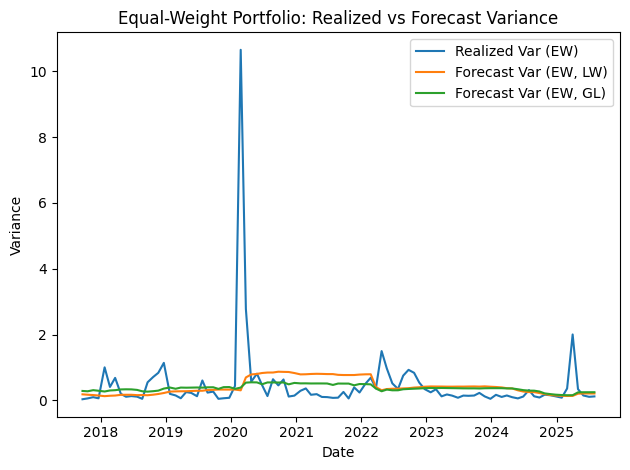

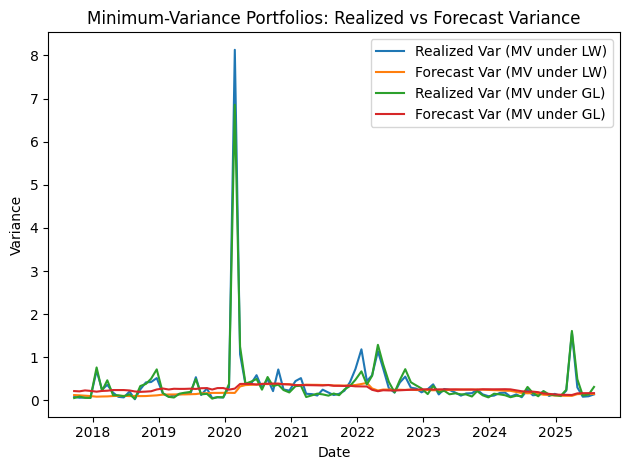

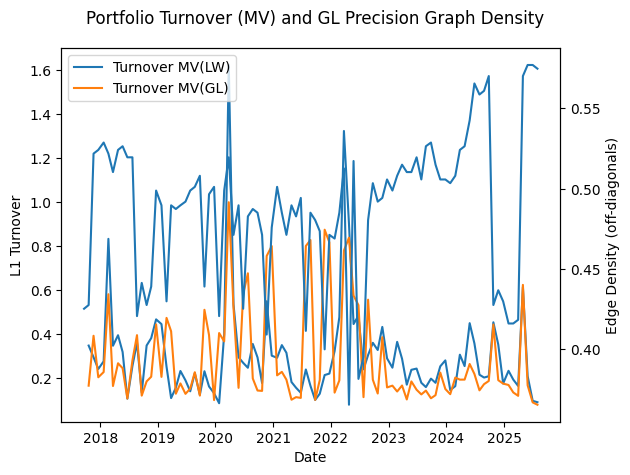

In [21]:

def summarize_forecast(realized, forecast):
    realized = np.asarray(realized, dtype=float)
    forecast = np.asarray(forecast, dtype=float)
    err = forecast - realized
    out = {
        'MSE': float(np.mean(err**2)),
        'MAE': float(np.mean(np.abs(err))),
        'Bias': float(np.mean(err)),
        'Corr': float(np.corrcoef(realized, forecast)[0,1]) if len(realized) > 1 else np.nan,
        'RelCalib': float(np.mean(forecast) / np.mean(realized)) if np.mean(realized) != 0 else np.nan,
    }
    return out

summary = pd.DataFrame({
    'EW_LW': summarize_forecast(res['rvar_EW'], res['fvar_EW_LW']),
    'EW_GL': summarize_forecast(res['rvar_EW'], res['fvar_EW_GL']),
    'MV_LW': summarize_forecast(res['rvar_MV_LW'], res['fvar_MV_LW']),
    'MV_GL': summarize_forecast(res['rvar_MV_GL'], res['fvar_MV_GL']),
}).T

print("Summary (lower MSE/MAE is better; RelCalib ~1 is ideal):")
display(summary.round(4))

# --- Plot 1: EW realized vs forecasts ---
plt.figure()
plt.plot(res.index, res['rvar_EW'], label='Realized Var (EW)')
plt.plot(res.index, res['fvar_EW_LW'], label='Forecast Var (EW, LW)')
plt.plot(res.index, res['fvar_EW_GL'], label='Forecast Var (EW, GL)')
plt.title('Equal-Weight Portfolio: Realized vs Forecast Variance')
plt.xlabel('Date'); plt.ylabel('Variance'); plt.legend(); plt.tight_layout(); plt.show()

# --- Plot 2: MV realized vs forecasts (both models) ---
plt.figure()
plt.plot(res.index, res['rvar_MV_LW'], label='Realized Var (MV under LW)')
plt.plot(res.index, res['fvar_MV_LW'], label='Forecast Var (MV under LW)')
plt.plot(res.index, res['rvar_MV_GL'], label='Realized Var (MV under GL)')
plt.plot(res.index, res['fvar_MV_GL'], label='Forecast Var (MV under GL)')
plt.title('Minimum-Variance Portfolios: Realized vs Forecast Variance')
plt.xlabel('Date'); plt.ylabel('Variance'); plt.legend(); plt.tight_layout(); plt.show()

# --- Plot 3: Stability & structure (turnover + sparsity) ---
fig, ax1 = plt.subplots()
ax1.plot(res.index, res['turn_MV_LW'], label='Turnover MV(LW)')
ax1.plot(res.index, res['turn_MV_GL'], label='Turnover MV(GL)')
ax1.set_xlabel('Date'); ax1.set_ylabel('L1 Turnover'); ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(res.index, res['density_GL'], label='GL Precision Edge Density')
ax2.set_ylabel('Edge Density (off-diagonals)')
fig.suptitle('Portfolio Turnover (MV) and GL Precision Graph Density')
fig.tight_layout(); plt.show()

# (Optional) Save figures for README
# fig_paths = ['ew_variance.png', 'mv_variance.png', 'turnover_sparsity.png']
# for i, f in enumerate(plt.get_fignums(), start=0):
#     plt.figure(f)
#     plt.savefig(fig_paths[i], dpi=150, bbox_inches='tight')
# print("Saved:", fig_paths)

## 5) Takeaways

- **Forecast accuracy**: Compare MSE/MAE and calibration ratio between LW and GL for EW and MV portfolios.
- **Stability**: Check MV turnover—does Graphical Lasso produce steadier weights? (Often sparser inverse structure can stabilize estimates.)
- **Structure**: Inspect `alpha_` chosen by `GraphicalLassoCV` and precision graph density—does it adapt across regimes?


In [22]:
# --- Setup: create figures folder ---
import os
os.makedirs("figures", exist_ok=True)

# --- Example: EW portfolio realized vs forecast variance ---
plt.figure(figsize=(10,6))
plt.plot(res.index, res['rvar_EW'], label="Realized Variance", lw=2)
plt.plot(res.index, res['fvar_EW_LW'], label="Forecast (Ledoit–Wolf)", lw=2)
plt.plot(res.index, res['fvar_EW_GL'], label="Forecast (Graphical Lasso)", lw=2)
plt.legend()
plt.title("Equal-Weight Portfolio: Realized vs Forecast Variance")
plt.xlabel("Date"); plt.ylabel("Variance")
plt.tight_layout()
plt.savefig("figures/ew_variance.png", dpi=150, bbox_inches="tight")
plt.close()

# --- Example: MV portfolio realized vs forecast variance ---
plt.figure(figsize=(10,6))
plt.plot(res.index, res['rvar_MV_LW'], label="Realized Var (LW)", lw=2)
plt.plot(res.index, res['fvar_MV_LW'], label="Forecast Var (LW)", lw=2, ls="--")
plt.plot(res.index, res['rvar_MV_GL'], label="Realized Var (GL)", lw=2)
plt.plot(res.index, res['fvar_MV_GL'], label="Forecast Var (GL)", lw=2, ls="--")
plt.legend()
plt.title("Min-Variance Portfolio: Realized vs Forecast Variance")
plt.xlabel("Date"); plt.ylabel("Variance")
plt.tight_layout()
plt.savefig("figures/mv_variance.png", dpi=150, bbox_inches="tight")
plt.close()

# --- Example: GL alpha path ---
plt.figure(figsize=(10,6))
plt.plot(res.index, res['alpha_GL'], lw=2)
plt.title("Graphical Lasso Selected Alpha over Time")
plt.xlabel("Date"); plt.ylabel("Alpha")
plt.tight_layout()
plt.savefig("figures/gl_alpha.png", dpi=150, bbox_inches="tight")
plt.close()

# --- Example: GL precision matrix sparsity ---
plt.figure(figsize=(10,6))
plt.plot(res.index, res['density_GL'], lw=2)
plt.title("Graphical Lasso Precision Matrix Density")
plt.xlabel("Date"); plt.ylabel("Density of Nonzeros")
plt.tight_layout()
plt.savefig("figures/gl_density.png", dpi=150, bbox_inches="tight")
plt.close()

print("✅ Figures saved to ./figures/ (ready for GitHub)")

✅ Figures saved to ./figures/ (ready for GitHub)
